In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b10_b25_b50_b75_t1_mask_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 474)
(631390, 1)
validation
(74368, 474)
(74368, 1)
test
(85358, 474)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 474)]             0         


 dense (Dense)               (None, 1024)              486400    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1175553 (4.48 MB)


Trainable params: 1175553 (4.48 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:29 - loss: 0.0554 - STD: 6.6215e-05 - MAE: 0.2271

 4/64 [>.............................] - ETA: 1s - loss: 0.0305 - STD: 1.0304e-04 - MAE: 0.1319  

 8/64 [==>...........................] - ETA: 0s - loss: 0.0281 - STD: 8.2386e-05 - MAE: 0.1235

12/64 [====>.........................] - ETA: 0s - loss: 0.0235 - STD: 7.8717e-05 - MAE: 0.1094

16/64 [======>.......................] - ETA: 0s - loss: 0.0218 - STD: 7.8612e-05 - MAE: 0.1098

19/64 [=======>......................] - ETA: 0s - loss: 0.0204 - STD: 7.7478e-05 - MAE: 0.1032

23/64 [=========>....................] - ETA: 0s - loss: 0.0194 - STD: 7.5566e-05 - MAE: 0.0960

26/64 [===========>..................] - ETA: 0s - loss: 0.0188 - STD: 7.5509e-05 - MAE: 0.0921

29/64 [============>.................] - ETA: 1s - loss: 0.0183 - STD: 7.6645e-05 - MAE: 0.0905

32/64 [==============>...............] - ETA: 1s - loss: 0.0178 - STD: 7.8484e-05 - MAE: 0.0902

36/64 [===============>..............] - ETA: 0s - loss: 0.0173 - STD: 8.0793e-05 - MAE: 0.0884

40/64 [=================>............] - ETA: 0s - loss: 0.0168 - STD: 8.3035e-05 - MAE: 0.0858

44/64 [===================>..........] - ETA: 0s - loss: 0.0165 - STD: 8.6011e-05 - MAE: 0.0841

48/64 [=====================>........] - ETA: 0s - loss: 0.0162 - STD: 8.9935e-05 - MAE: 0.0835

51/64 [======================>.......] - ETA: 0s - loss: 0.0159 - STD: 9.3120e-05 - MAE: 0.0829

54/64 [========================>.....] - ETA: 0s - loss: 0.0158 - STD: 9.6334e-05 - MAE: 0.0821

58/64 [==========================>...] - ETA: 0s - loss: 0.0155 - STD: 1.0091e-04 - MAE: 0.0810

62/64 [============================>.] - ETA: 0s - loss: 0.0154 - STD: 1.0628e-04 - MAE: 0.0804

64/64 [==============================] - 4s 37ms/step - loss: 0.0153 - STD: 1.0916e-04 - MAE: 0.0802 - val_loss: 0.0167 - val_STD: 1.7072e-04 - val_MAE: 0.0818


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0129 - STD: 2.0627e-04 - MAE: 0.0734

 5/64 [=>............................] - ETA: 0s - loss: 0.0128 - STD: 2.1578e-04 - MAE: 0.0711

 9/64 [===>..........................] - ETA: 0s - loss: 0.0128 - STD: 2.2656e-04 - MAE: 0.0703

13/64 [=====>........................] - ETA: 0s - loss: 0.0128 - STD: 2.3923e-04 - MAE: 0.0705

17/64 [======>.......................] - ETA: 0s - loss: 0.0127 - STD: 2.5271e-04 - MAE: 0.0705

21/64 [========>.....................] - ETA: 0s - loss: 0.0127 - STD: 2.6708e-04 - MAE: 0.0703

25/64 [==========>...................] - ETA: 0s - loss: 0.0127 - STD: 2.8303e-04 - MAE: 0.0701

28/64 [============>.................] - ETA: 0s - loss: 0.0127 - STD: 2.9645e-04 - MAE: 0.0701

32/64 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 3.1571e-04 - MAE: 0.0702

36/64 [===============>..............] - ETA: 0s - loss: 0.0127 - STD: 3.3690e-04 - MAE: 0.0700

40/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 3.6115e-04 - MAE: 0.0700

43/64 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 3.8139e-04 - MAE: 0.0700

47/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 4.1107e-04 - MAE: 0.0700

51/64 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 4.4516e-04 - MAE: 0.0699

55/64 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 4.8454e-04 - MAE: 0.0699

59/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 5.3042e-04 - MAE: 0.0699

62/64 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 5.6969e-04 - MAE: 0.0699

64/64 [==============================] - 1s 18ms/step - loss: 0.0126 - STD: 5.9899e-04 - MAE: 0.0699 - val_loss: 0.0165 - val_STD: 0.0013 - val_MAE: 0.0788


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0126 - STD: 0.0016 - MAE: 0.0699

 5/64 [=>............................] - ETA: 0s - loss: 0.0123 - STD: 0.0018 - MAE: 0.0689

 9/64 [===>..........................] - ETA: 0s - loss: 0.0124 - STD: 0.0020 - MAE: 0.0690

13/64 [=====>........................] - ETA: 0s - loss: 0.0123 - STD: 0.0022 - MAE: 0.0691

17/64 [======>.......................] - ETA: 0s - loss: 0.0123 - STD: 0.0025 - MAE: 0.0688

21/64 [========>.....................] - ETA: 0s - loss: 0.0123 - STD: 0.0029 - MAE: 0.0687

25/64 [==========>...................] - ETA: 0s - loss: 0.0122 - STD: 0.0034 - MAE: 0.0685

29/64 [============>.................] - ETA: 0s - loss: 0.0121 - STD: 0.0040 - MAE: 0.0683

33/64 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 0.0049 - MAE: 0.0680

37/64 [================>.............] - ETA: 0s - loss: 0.0118 - STD: 0.0061 - MAE: 0.0674

40/64 [=================>............] - ETA: 0s - loss: 0.0117 - STD: 0.0074 - MAE: 0.0669

44/64 [===================>..........] - ETA: 0s - loss: 0.0114 - STD: 0.0095 - MAE: 0.0657

48/64 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 0.0125 - MAE: 0.0644

52/64 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 0.0163 - MAE: 0.0630

55/64 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 0.0195 - MAE: 0.0619

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 0.0229 - MAE: 0.0608

62/64 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.0273 - MAE: 0.0593

64/64 [==============================] - 1s 19ms/step - loss: 0.0093 - STD: 0.0294 - MAE: 0.0586 - val_loss: 0.0034 - val_STD: 0.0803 - val_MAE: 0.0375


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0973 - MAE: 0.0338

 5/64 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0331

 8/64 [==>...........................] - ETA: 0s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0326

12/64 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0998 - MAE: 0.0321

16/64 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0318

20/64 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0316

24/64 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0314

28/64 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0312

32/64 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0311

36/64 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0310

40/64 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

44/64 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

48/64 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0307

52/64 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0307

56/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0306

60/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0305

64/64 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0305

64/64 [==============================] - 1s 18ms/step - loss: 0.0021 - STD: 0.1027 - MAE: 0.0305 - val_loss: 0.0023 - val_STD: 0.0843 - val_MAE: 0.0312


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0293

 5/64 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.1020 - MAE: 0.0300

 9/64 [===>..........................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

13/64 [=====>........................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

17/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

21/64 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0300

25/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

29/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

33/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0298

36/64 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0298

40/64 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0297

44/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0297

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0296

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0296

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

64/64 [==============================] - 1s 18ms/step - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295 - val_loss: 0.0023 - val_STD: 0.0880 - val_MAE: 0.0309


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0292

 5/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0289

 9/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0288

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

20/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0289

27/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0289

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0289

38/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0289

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

64/64 [==============================] - 1s 18ms/step - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288 - val_loss: 0.0020 - val_STD: 0.0870 - val_MAE: 0.0293


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0284

 8/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0285

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

19/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0284

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0285

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0284

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0284

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0284

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0284

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0283

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0283

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0283

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0283

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0282

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0283

64/64 [==============================] - 1s 19ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0283 - val_loss: 0.0019 - val_STD: 0.0854 - val_MAE: 0.0285


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0285

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

21/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0292

24/64 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0291

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0285

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0285

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0284

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0284

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0283

64/64 [==============================] - 1s 19ms/step - loss: 0.0018 - STD: 0.1041 - MAE: 0.0283 - val_loss: 0.0018 - val_STD: 0.0862 - val_MAE: 0.0281


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0275

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0279

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0278

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0277

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0277

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0277

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0277

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0277

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0277

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

64/64 [==============================] - 1s 18ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0276 - val_loss: 0.0018 - val_STD: 0.0884 - val_MAE: 0.0284


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0273

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0276

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0276

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0275

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0275

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0276

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0277

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0277

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0277

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0276

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0276

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0276

64/64 [==============================] - 1s 18ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0276 - val_loss: 0.0018 - val_STD: 0.0896 - val_MAE: 0.0279


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1098 - MAE: 0.0269

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0273

 8/64 [==>...........................] - ETA: 0s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0276

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0276

15/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0275

18/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0275

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0274

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

64/64 [==============================] - 1s 18ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0899 - val_MAE: 0.0291


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1092 - MAE: 0.0281

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

10/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0275

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0275

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0274

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0274

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0273

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271 - val_loss: 0.0017 - val_STD: 0.0866 - val_MAE: 0.0270


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0265

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0274

 8/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0274

11/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0273

14/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0274

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0274

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0274

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272 - val_loss: 0.0016 - val_STD: 0.0869 - val_MAE: 0.0269


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0266

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270 - val_loss: 0.0016 - val_STD: 0.0856 - val_MAE: 0.0267


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0270

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0276

 7/64 [==>...........................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269 - val_loss: 0.0016 - val_STD: 0.0865 - val_MAE: 0.0266


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0277

12/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0275

15/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0274

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

64/64 [==============================] - 1s 18ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0932 - val_MAE: 0.0301


Epoch 17/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1130 - MAE: 0.0283

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0279

 7/64 [==>...........................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0275

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

20/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

23/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267 - val_loss: 0.0016 - val_STD: 0.0867 - val_MAE: 0.0264


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0264

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0266

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0266

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0266

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0266

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0266

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0266

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0266

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0888 - val_MAE: 0.0267


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0263

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0265

14/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0266

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0266

20/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0266

23/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0266

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0268

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0268

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267 - val_loss: 0.0016 - val_STD: 0.0845 - val_MAE: 0.0263


Epoch 20/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267 - val_loss: 0.0015 - val_STD: 0.0853 - val_MAE: 0.0262


Epoch 21/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0271

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0264

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0889 - val_MAE: 0.0266


Epoch 22/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0255

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0886 - val_MAE: 0.0269


Epoch 23/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0259

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0259

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0931 - val_MAE: 0.0299


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1095 - MAE: 0.0274

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 0s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0267

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0265

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0924 - val_MAE: 0.0280


Epoch 25/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0265

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0261

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0260

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.0862 - val_MAE: 0.0259


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0270

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0909 - val_MAE: 0.0286


Epoch 27/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0259

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0259

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0260

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0261

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0259

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0902 - val_MAE: 0.0273


Epoch 28/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0259

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0260

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0260

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0261

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0261

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259 - val_loss: 0.0017 - val_STD: 0.0912 - val_MAE: 0.0282


Epoch 29/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258 - val_loss: 0.0017 - val_STD: 0.0919 - val_MAE: 0.0277


Epoch 30/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0257

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0259

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258 - val_loss: 0.0015 - val_STD: 0.0896 - val_MAE: 0.0265


Epoch 31/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0254

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0256

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0256

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0257

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0258

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0258

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0017 - val_STD: 0.0916 - val_MAE: 0.0281


Epoch 32/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1100 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0259

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0258

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.0913 - val_MAE: 0.0269


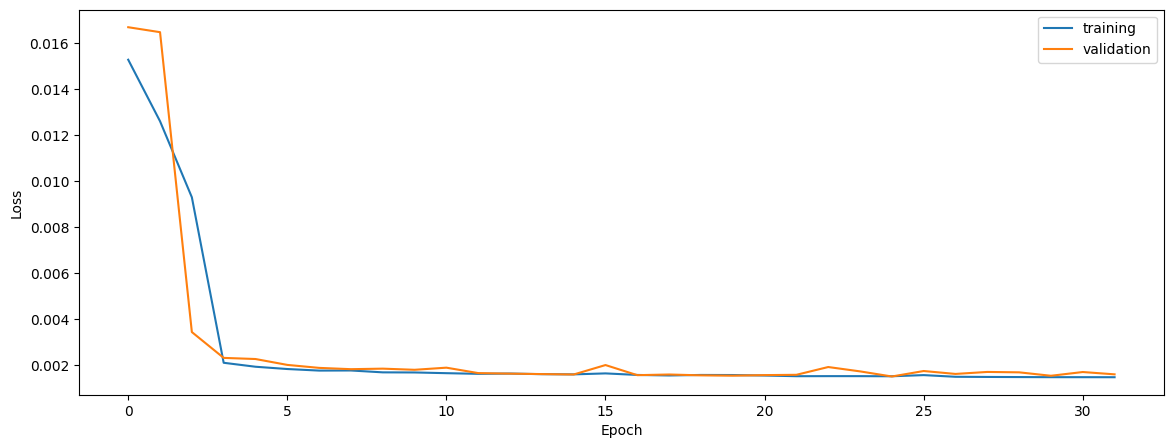

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


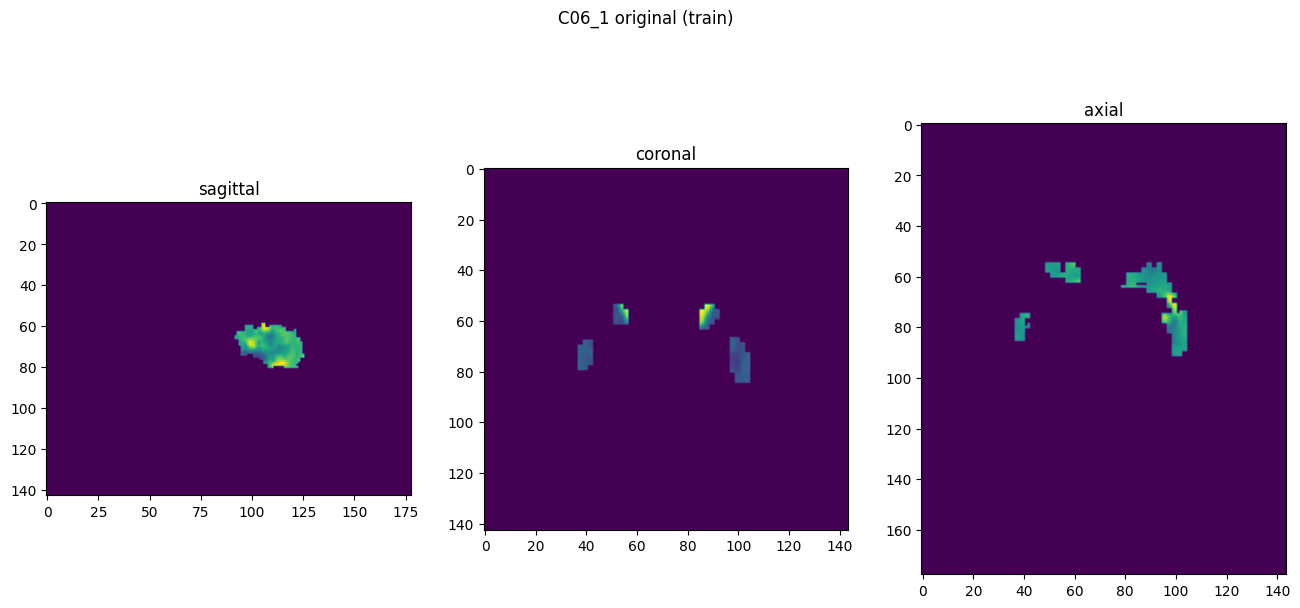

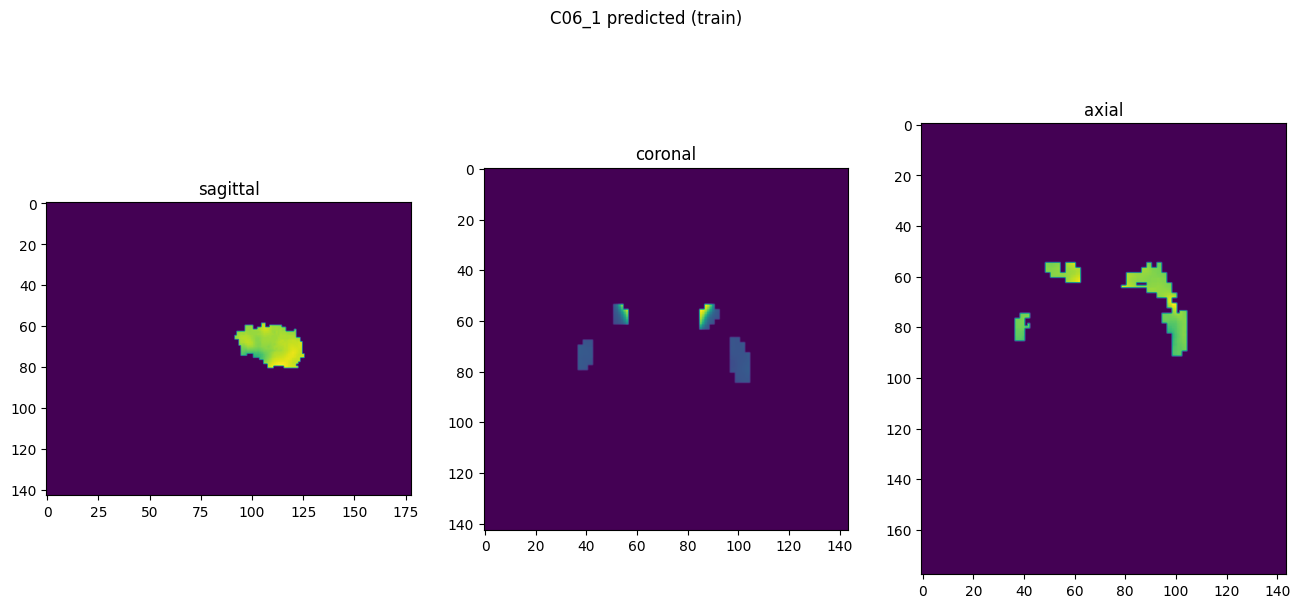

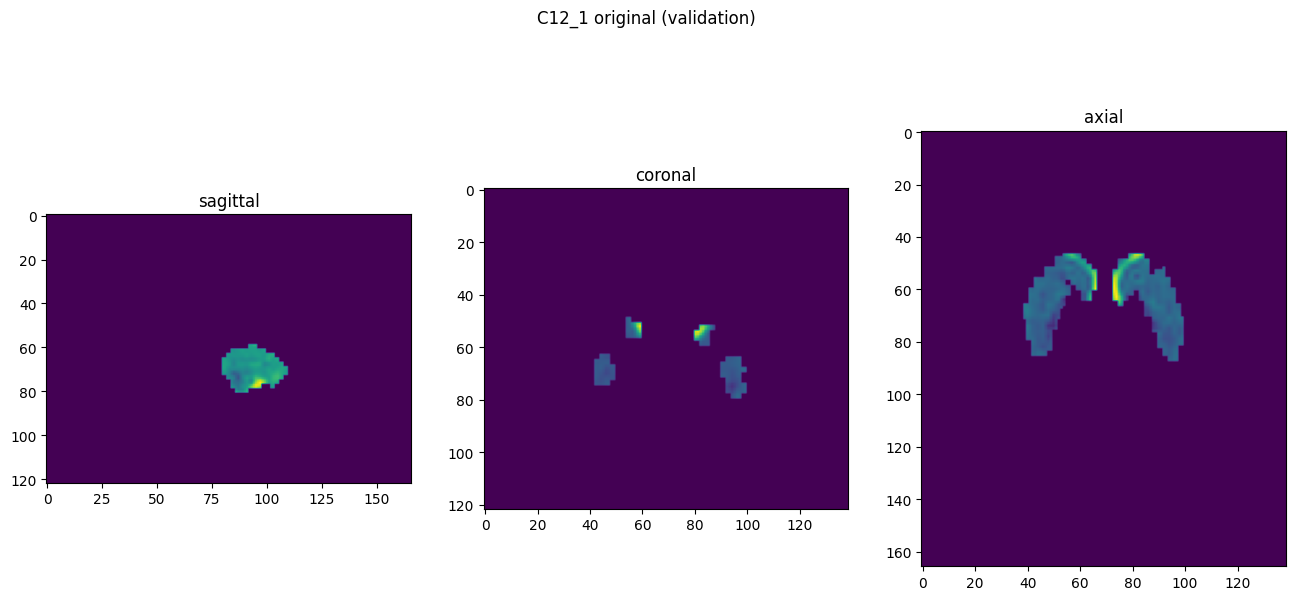

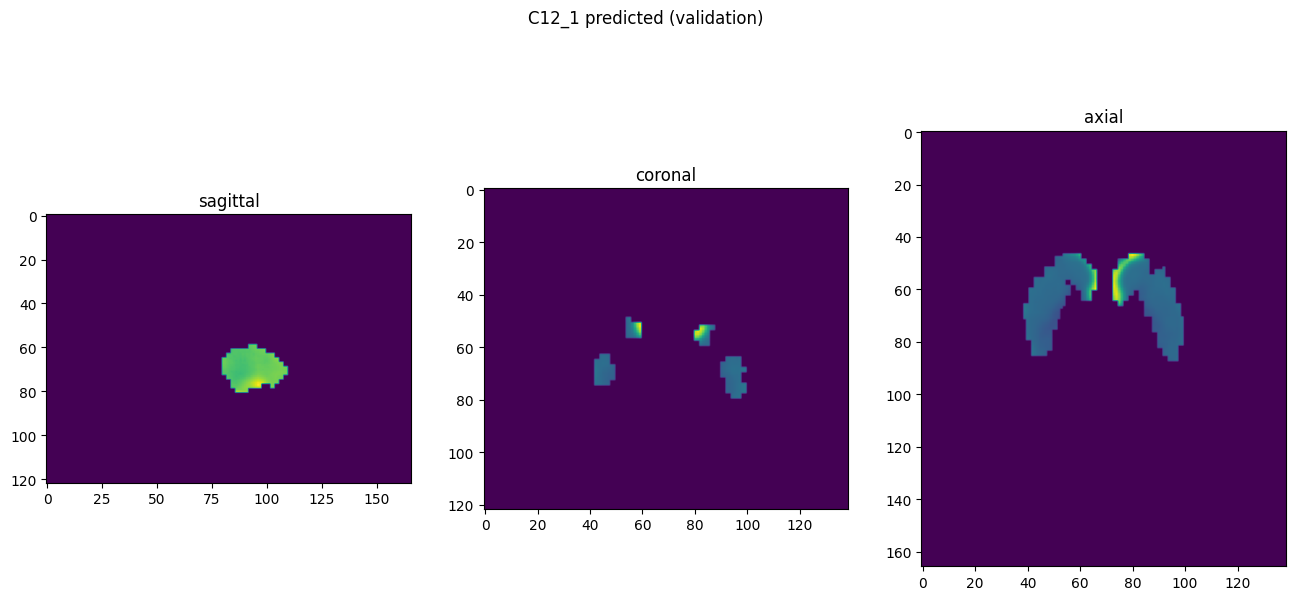

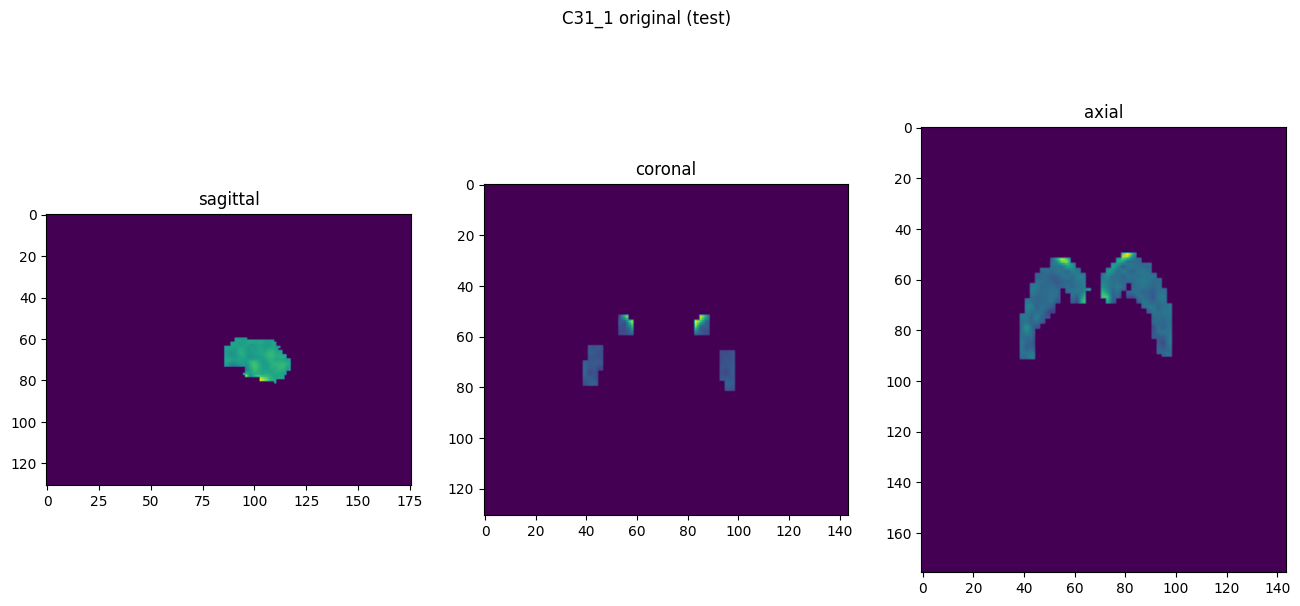

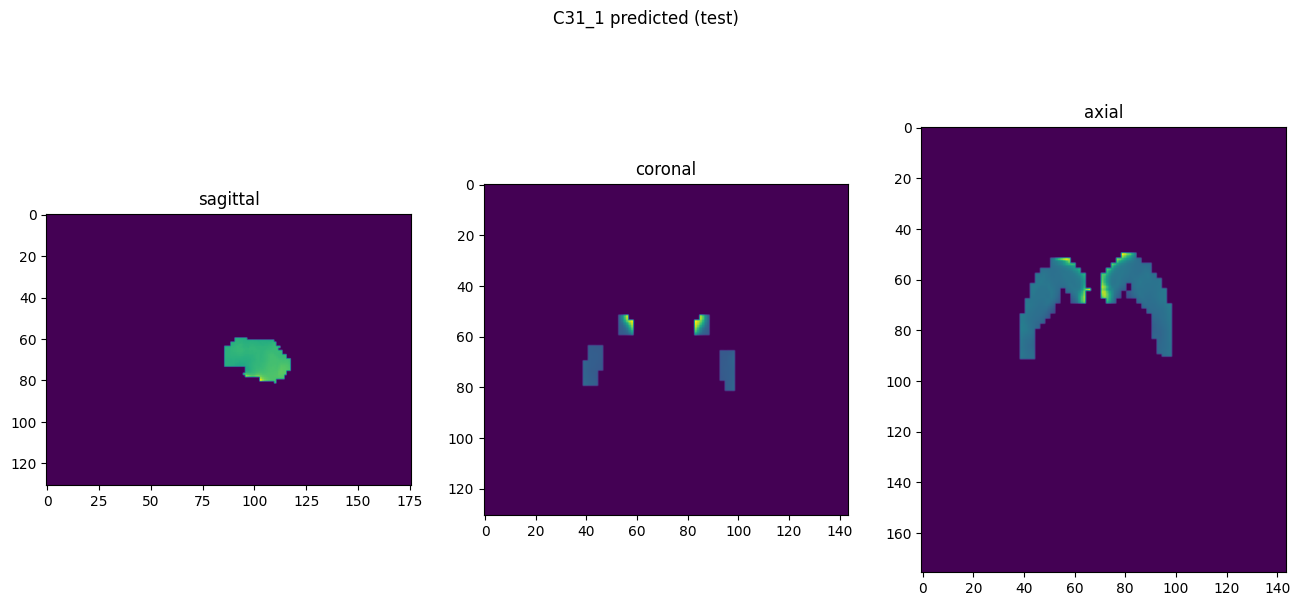

In [10]:
showResults(model, gen, threshold=None, background=False)